In [1]:

import matplotlib as mpl

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 25
mpl.rcParams['text.usetex'] = False

In [2]:
from scipy.spatial import Delaunay
#import polyscope as ps


# ddg imports
import os, sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from ddgclib._complex import *
from ddgclib._sphere import *


def distance(a, b):
    return np.linalg.norm(a - b)

def barycenter(vertices):
    """
    Compute the barycenter (centroid) of a triangle
    """
    return np.mean(vertices, axis=0)


def compute_vd_barycentric(HC, cdist=1e-10):
    """
    Compute dual vertices using barycenter instead of circumcenter
    """
    HC.Vd = VertexCacheField()
    for v in HC.V:
        v.vd = set()

    for v1 in HC.V:
        for v2 in v1.nn:
            shared = v1.nn.intersection(v2.nn)
            for v3 in shared:
                verts = np.array([v1.x_a, v2.x_a, v3.x_a])
                cd = barycenter(verts)

                # Check uniqueness
                for vd_i in HC.Vd:
                    if np.linalg.norm(vd_i.x_a - cd) < cdist:
                        cd = vd_i.x_a

                vd = HC.Vd[tuple(cd)]
                for v in [v1, v2, v3]:
                    v.vd.add(vd)
                    vd.nn.add(v)
    return HC



# Find the Delaunay dual
def triang_dual(points, plot_delaunay=False):
    """
    Compute the Delaunay triangulation plus the dual points. Put into hyperct complex object.

    """
    tri = Delaunay(points)
    if plot_delaunay:  # Plot Delaunay complex
        import matplotlib.pyplot as plt
        plt.triplot(points[:,0], points[:,1], tri.simplices)
        plt.plot(points[:,0], points[:,1], 'o')
        plt.show()

    # Put Delaunay back into hyperct Complex object:
    HC = Complex(2)
    for s in tri.simplices:
        for v1i in s:
            for v2i in s:
                if v1i is v2i:
                    continue
                else:
                    v1 = tuple(points[v1i])
                    v2 = tuple(points[v2i])
                    HC.V[v1].connect(HC.V[v2])

    return HC, tri


# Plot duals
def plot_dual_mesh_2D(HC, tri):
    """
    Plot the dual mesh and show edge connectivity. Blue is the primary mesh. Orange is the dual mesh.
    """
    import matplotlib.pyplot as plt

    # Find the dual points
    dual_points = []
    for vd in HC.Vd:
        #print('-')
        #print(vd.x_a)
        dual_points.append(vd.x_a)
        #for vdn in vd.v
    dual_points = np.array(dual_points)

    for v in HC.V:
        # "Connect duals":
        for v2 in v.nn:
            v1vdv2vd = v.vd.intersection(v2.vd)  # Cardinality always 1 or 2?
            if len(v1vdv2vd) == 1:
                continue
            v1vdv2vd = list(v1vdv2vd)
            x = [v1vdv2vd[0].x[0], v1vdv2vd[1].x[0]]
            y = [v1vdv2vd[0].x[1], v1vdv2vd[1].x[1]]
            plt.plot(x, y, color='orange')

        for vd in v.vd:
            x = [v.x[0], vd.x[0]]
            y = [v.x[1], vd.x[1]]
            #plt.plot(x, y, '--', color='tab:green')
    plt.triplot(points[:,0], points[:,1], tri.simplices, color='tab:blue')
    plt.plot(points[:,0], points[:,1],  'o', color='tab:blue')
    plt.plot(dual_points[:,0], dual_points[:,1], 'o', color='tab:orange')

    plt.show()

# Area computations
def d_area_barycentric(vp1):
    """
    Compute dual area using barycenters
    """
    darea = 0
    for vp2 in vp1.nn:
        shared = vp1.nn.intersection(vp2.nn)
        for vp3 in shared:
            verts = np.array([vp1.x_a, vp2.x_a, vp3.x_a])
            bc = barycenter(verts)
            # Area of triangle = 0.5 * ||AB x AC|| for 2D ABxAC gives scalar area
            A = vp1.x_a
            B = vp2.x_a
            C = bc
            area = 0.5 * np.abs((B[0]-A[0])*(C[1]-A[1]) - (C[0]-A[0])*(B[1]-A[1]))
            darea += area
    return darea




## This test case
# Test case traingulation
def incom_Poi(domain, refinements=2):
    """
    Compute the triangulate of a 2D incompressible Poiseuile flow
    """
    HC = Complex(2, domain)
    HC.triangulate()
    for i in range(refinements):
        HC.refine_all()

    points = []
    for v in HC.V:
        points.append(v.x_a)
    points = np.array(points)
    tri = Delaunay(points)
    return points

def u_x_analytical(y):
    """
    General pipe solution (NOT planar case)
    """
    return 4 * y * (1 - y)

def u_plane_analytical(x):
    y = x[1]
    return (G / 2 * mu) * y * (h - y)

def v_error(HC):
    MSE = 0
    for v in HC.V:
        u_anal = u_plane_analytical(v.x_a)
        MSE += (v.u[1]- u_anal)**2
    return MSE

## Initial conditions
# velocity
def v_IC(HC):
    # Assign velocity field to all points:
    for v in HC.V:
        v.u = np.array([u_ic(v.x_a), 0])

# mass
def mass_IC(HC):
    # Set mass of each fluid particle:
    for v in HC.V:
        # Compute the dual area around a particle:
        area = d_area_barycentric(v)  # <- use barycentric version
        V = area * 1  # m3, can be modified later
        # Set mass in kg
        v.m = rho * V



# Plots
def plot_field(p, u, xlim_lb=-1, xlim_ub=10, scale=1):
    """
    Plot the velocity fields using points `p` and
    associated velocities `u`.

    scale adjusts the scale of the shown arrow factors
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize

    positions = p
    velocities = u

    # Separate the positions and velocities into x, y, u, and v arrays
    x, y = positions[:, 0], positions[:, 1]
    u, v = velocities[:, 0], velocities[:, 1]

    # Calculate the magnitude of the velocity vectors
    magnitude = np.sqrt(u**2 + v**2)  # Should be around 0.1

    # Set the normalization range for the colors of the arrows based on the actual magnitudes
    norm = Normalize(vmin=magnitude.min(), vmax=magnitude.max())

    plt.figure(figsize=(8, 8))
    quiver_plot = plt.quiver(x, y, u, v, magnitude, norm=norm, cmap='viridis', scale=scale)
    plt.scatter(x, y, s=0.1)
    #plt.colorbar(label='Magnitude of Velocity')
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    #cbar = plt.colorbar(quiver_plot, format=ticker.FuncFormatter(fmt))
    cbar = plt.colorbar(quiver_plot)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.formatter.set_useMathText(True)
    cbar.set_label('Magnitude of Velocity (m/s)')
    #plt.title('Quiver Plot from Position Points and Velocity Vectors')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.xlim(xlim_lb, xlim_ub)
    plt.ylim(0, 1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.show()

def plot_discrete_field(p, u, HC, tri, xlim_lb=0, xlim_ub=1, scale=1e-6, save='vector_int.pdf'):
    """
    Plot the velocity fields using points `p` and
    associated velocities `u`.

    vfac adjusts the arrow length to account for very low velocities in the field
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Find the dual points
    dual_points = []
    for vd in HC.Vd:
        #print('-')
        #print(vd.x_a)
        dual_points.append(vd.x_a)
        #for vdn in vd.v
    dual_points = np.array(dual_points)

    for v in HC.V:
        # "Connect duals":
        for v2 in v.nn:
            v1vdv2vd = v.vd.intersection(v2.vd)  # Cardinality always 1 or 2?
            if len(v1vdv2vd) == 1:
                continue
            v1vdv2vd = list(v1vdv2vd)
            x = [v1vdv2vd[0].x[0], v1vdv2vd[1].x[0]]
            y = [v1vdv2vd[0].x[1], v1vdv2vd[1].x[1]]
            plt.plot(x, y, color='orange')

        for vd in v.vd:
            x = [v.x[0], vd.x[0]]
            y = [v.x[1], vd.x[1]]
            #plt.plot(x, y, '--', color='tab:green')
    plt.triplot(points[:,0], points[:,1], tri.simplices, color='tab:blue')
    plt.plot(points[:,0], points[:,1],  'o', color='tab:blue')
    plt.plot(dual_points[:,0], dual_points[:,1], 'o', color='tab:orange')

    ## Velocity
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize

    positions = p
    velocities = u

    # Separate the positions and velocities into x, y, u, and v arrays
    x, y = positions[:, 0], positions[:, 1]
    u, v = velocities[:, 0], velocities[:, 1]

    # Calculate the magnitude of the velocity vectors
    magnitude = np.sqrt(u**2 + v**2)  # Should be around 0.1

    # Set the normalization range for the colors of the arrows based on the actual magnitudes
    norm = Normalize(vmin=magnitude.min(), vmax=magnitude.max())

    #plt.figure(figsize=(8, 8))
    quiver_plot = plt.quiver(x, y, u, v, magnitude, norm=norm, cmap='viridis', scale=scale)
    plt.scatter(x, y, s=0.1)
    #plt.colorbar(label='Magnitude of Velocity')

    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    #cbar = plt.colorbar(quiver_plot, format=ticker.FuncFormatter(fmt))
    cbar = plt.colorbar(quiver_plot)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.formatter.set_useMathText(True)
    cbar.set_label('Magnitude of Velocity (m/s)')
    #plt.title('Quiver Plot from Position Points and Velocity Vectors')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.xlim(xlim_lb, xlim_ub)
    plt.ylim(0, 1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    if save:
        plt.savefig(save)
    plt.show()




# Incompressible Poiseuille channel fluid flow

The incompressible Navier-Stokes equations are:
$$
\begin{aligned}
\rho\left(\frac{\partial u}{\partial t}+u \cdot \nabla u\right) & =\nabla \cdot \sigma(u, p)+f \\
\nabla \cdot u & =0 .
\end{aligned}
$$

for a Newtonian fluid we have
$$
\sigma(u, p)=2 \mu \epsilon(u)-p I
$$
where $\epsilon(u)$ is the strain-rate tensor
$$
\epsilon(u)=\frac{1}{2}\left(\nabla u+(\nabla u)^T\right)
$$

In standard fluid-kinetics notation:

$$
\Delta p=\frac{8 \mu L Q}{\pi R^4}=\frac{8 \pi \mu L Q}{A^2}
$$

where:
- $\Delta p$ is the pressure difference between the two ends,
- $L$ is the length of pipe,
- $\mu$ is the dynamic viscosity,
- $Q$ is the volumetric flow rate,
- $R$ is the pipe radius,
- $A$ is the cross sectional area of pipe.

In [3]:
import numpy as np

mu = 8.90 * 1e-4  # Pa·s
L = 1  # m
Q = 1  # m3 / s
R = 1  # m
A = 1  # m2  # = 2 pi * R**2 # for pipe
# Pressure drop for pipe
dP_anal = (8 * np.pi * mu * L * Q) / (A ** 2)
P_in = 101325  # Pa (kg⋅m−1⋅s−2), atmospheric pressure


def P_ic(x):
    """
    Initial pressure condition (ASSUMED linear based on pressure drop)
    """
    return P_in - ((8 * np.pi * mu * x * Q) / (A ** 2))  # P_in - dP


# Pressure IC (new)
def P_IC(HC):
    # Assign velocity field to all points:
    for v in HC.V:
        # NOTE: We assume that the vector here is in fact the
        #       pressure _gradient_ potential, which is not
        #       equivalt to the scalar pressure field.
        P_i = P_ic(v.x_a[0])
        v.P = np.array([P_i, P_i])  # Diagonal components


# Physical parameters
h = R  # m, plate seperation
Q = 1  # m/s, specify volumetric flowrate
G = (Q * 12 * mu) / (h ** 3)
rho = 1000  # kg / m3


#G = dP/ L

# Initial condition:
def u_ic(x):
    y = x[1]
    return (G / 2 * mu) * y * (h - y)


# Solution
def u_plane_analytical(x):
    y = x[1]
    return (G / 2 * mu) * y * (h - y)


# Boundary conditions:
def u_bc(x):
    y = x[1]
    if y == 0:
        return 0.0
    elif y == h:
        return 0.0



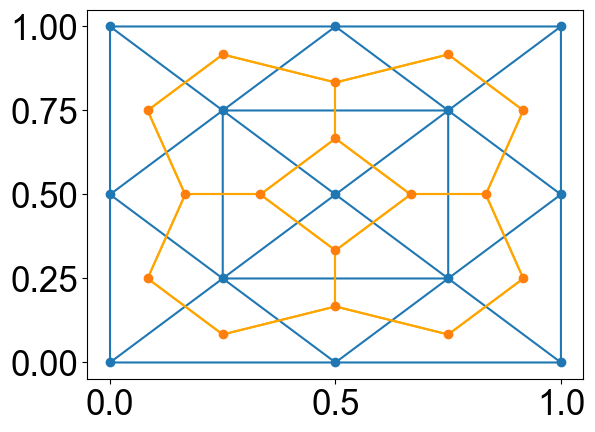

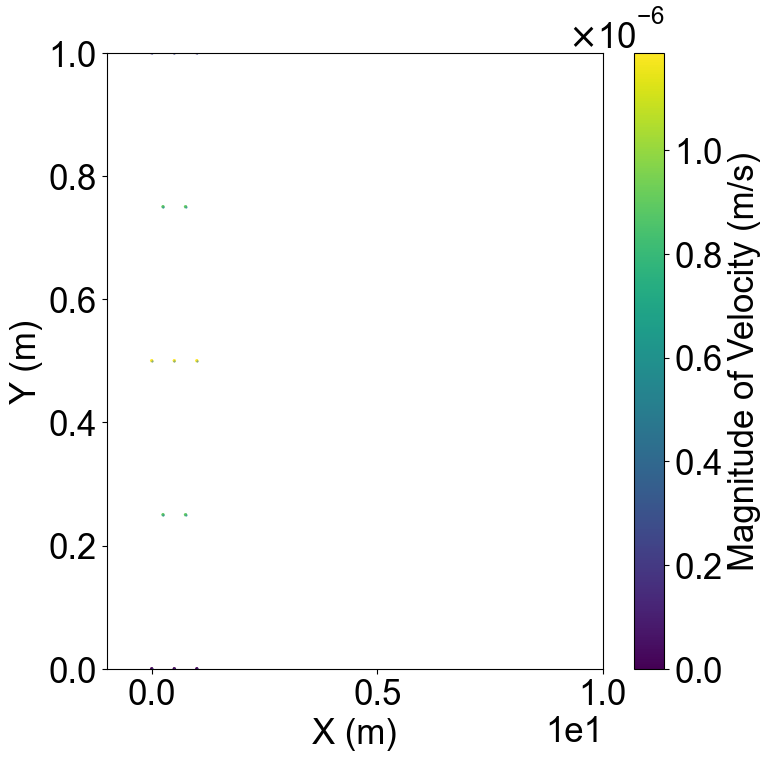

Error = 7.411427218125e-12


In [4]:
# Solid boundaries of plate
x_lb = 0
x_ub = R  # For simplicity
y_lb = 0
y_ub = R  # Actual parallel plate dimension
domain = [(x_lb, x_ub), (y_lb, y_ub)]
points = incom_Poi(domain, refinements=1)
HC, tri = triang_dual(points)
#HC.vertex_face_mesh(field_conversions=True)
HC = compute_vd_barycentric(HC)
plot_dual_mesh_2D(HC, tri)


# For each vertex compute its local dual area:

Areas = []
for vp1 in HC.V:
    area = 0
    area += d_area_barycentric(vp1)
    Areas.append(area)

# Set ICs:
mass_IC(HC)  # mass IC
v_IC(HC)  # Velocity IC
P_IC(HC)  # Pressure field IC

# Plot IC velocity field
p = []
u = []
for v in HC.V:
    p.append(v.x_a)
    u.append(v.u)

p = np.array(p)
u = np.array(u)
plot_field(p, u)
print(f'Error = {v_error(HC)}')

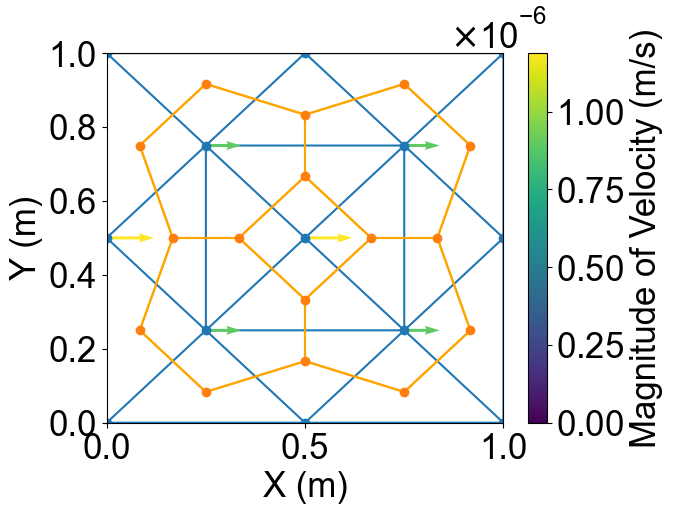

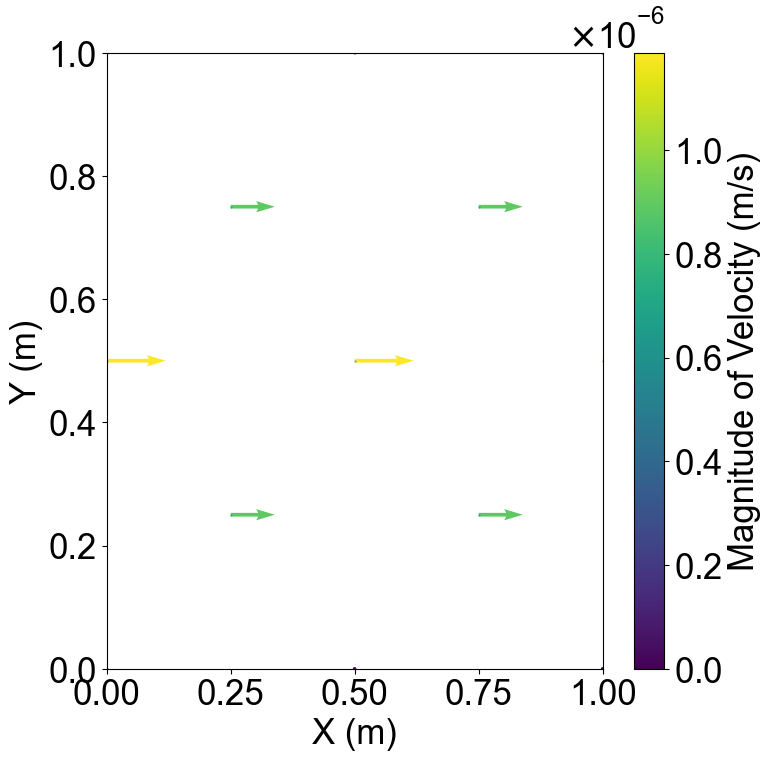

Error = 7.411427218125e-12


In [5]:
mpl.rcParams['font.size'] = 25#30
plot_discrete_field(p, u, HC, tri, scale=1e-5)

mpl.rcParams['font.size'] = 25
# Plot IC velocity field
p = []
u = []
for v in HC.V:
    p.append(v.x_a)
    u.append(v.u)

p = np.array(p)
u = np.array(u)
plot_field(p, u, xlim_lb=0, xlim_ub=1, scale=1e-5)
print(f'Error = {v_error(HC)}')